## Benchmarking - Plot image matching

### Import

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from cv2 import circle
import numpy as np
import cv2 as cv
from kornia.feature import LoFTR

import torch
from models.matching import Matching
from cv_image_matching.utils.utils import get_images, run_feature_extracion_own

from cv_image_matching.benchmarks.fundamental_matrix import run_feature_extraction_loftr
from cv_image_matching.utils.utils import get_matches, make_matching_plot

### Load data

In [2]:
src = "../data/train"
folder = "lincoln_memorial_statue"
idx = 18
data_path = src + "/" + folder + "/pair_covisibility.csv"
img_size = (200, 200)
data = pd.read_csv(data_path)

img1_id = data.iloc[idx]["pair"].split("-")[0]
img2_id = data.iloc[idx]["pair"].split("-")[1]

img1_path = src + "/" + folder + "/images/" + img1_id + ".jpg"
img2_path = src + "/" + folder + "/images/" + img2_id + ".jpg"

gray1, gray2, resized_img1, resized_img2 = get_images(
    img1_path,
    img2_path,
    img_size,
    show=False,
)

### Own SIFT

In [8]:
params_sift = {
    "kp_find_threshold": 1,
    "kp_max_tolerance": 0,
    "local_max_threshold": 10,
    "initial_sigma": 1.6,
    "n_scales_per_octave": 3,
    "n_octaves": 8,
    "assumed_blur": 0.5,
    "gaussian_window_histogram": 1.5,
    "num_bins_histogram": 180,
    "ksize_smooth_histogram": 5,
    "std_smooth_histogram": 1,
    "size_factor": 5,
    "n_spacial_bins": 4,
    "n_orientation_bins": 8,
    "f_max": 0.2,
    "f_scale": 512,
    "descriptor_filter_scale_factor": 0.25,
    "descriptor_cutoff_factor": 2.5,
}
experiments = ["own_sift", "opencv_sift", "superglue", "loftr"]

kp1, des1, kp2, des2 = run_feature_extracion_own(gray1, gray2, params_sift)
matches = get_matches(des1, des2)

matches1to2 = []
for m in matches:
    if m[0].distance < 0.8 * m[1].distance:
        matches1to2.append(m[0])
img_own_1 = cv.drawMatches(resized_img1, kp1, resized_img2, kp2, matches1to2, None)

Calculated keypoints and descriptors for image 1
Time taken for own SIFT:  6.3613951206207275  seconds
Calculated keypoints and descriptors for image 2
Time taken for OpenCV SIFT:  7.301836729049683  seconds


Text(0.5, 1.0, 'Own SIFT')

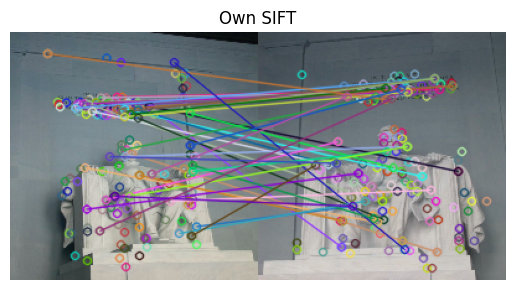

In [9]:
plt.imshow(img_own_1)
plt.axis("off")
plt.title("Own SIFT")

### OpenCV SIFT

In [10]:
sift_opencv = cv.SIFT_create()
kp1, des1 = sift_opencv.detectAndCompute(resized_img1.copy(), None)
kp2, des2 = sift_opencv.detectAndCompute(resized_img2.copy(), None)
matches = get_matches(des1, des2)

matches1to2 = []
for m in matches:
    if m[0].distance < 0.9*m[1].distance:
        matches1to2.append(m[0])
img_opencv = cv.drawMatches(resized_img1, kp1, resized_img2, kp2, matches1to2, None)

Text(0.5, 1.0, 'OpenCV SIFT')

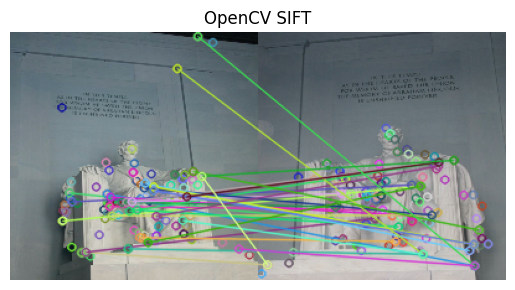

In [11]:
plt.imshow(img_opencv)
plt.axis("off")
plt.title("OpenCV SIFT")

### SuperGlue

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "superpoint": {
        "nms_radius": 3,
        "keypoint_threshold": 0.005,
        "max_keypoints": 2048,
    },
    "superglue": {
        "weights": "outdoor",
        "sinkhorn_iterations": 100,
        "match_threshold": 0.2,
    },
}
matching = Matching(config).eval().to(device)
img1_glue = torch.from_numpy(gray1)[None][None] / 255.0
img2_glue = torch.from_numpy(gray2)[None][None] / 255.0

pred = matching({"image0": img1_glue, "image1": img2_glue})
pred = {k: v[0].detach().cpu().numpy() for k, v in pred.items()}

matches = pred["matches0"]
kp1, kp2 = pred["keypoints0"], pred["keypoints1"]
valid = matches > -1
mkpts1 = kp1[valid]
mkpts2 = kp2[matches[valid]]

Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


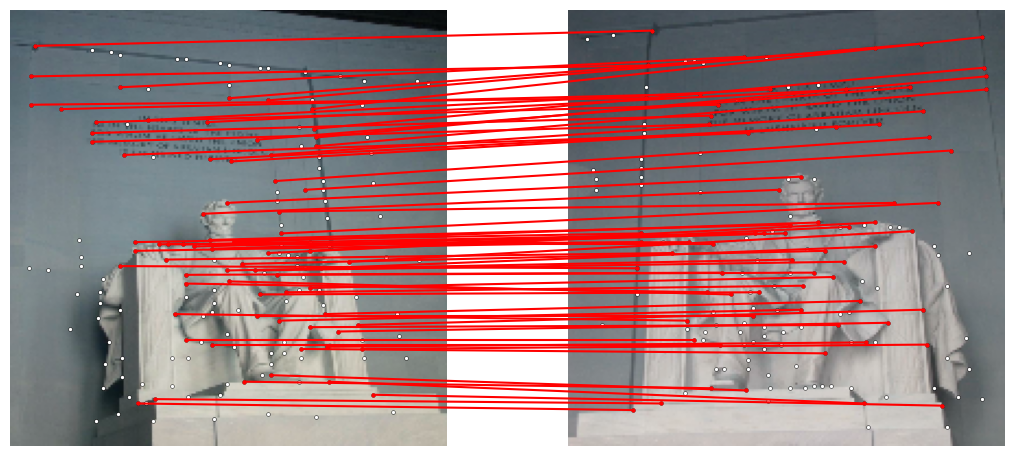

In [24]:
make_matching_plot(resized_img1, resized_img2, kp1, kp2, mkpts1, mkpts2, show_keypoints=True, fast_viz=True)

### LoFTR

In [15]:
img1 = torch.from_numpy(gray1)[None][None] / 255.0
img2 = torch.from_numpy(gray2)[None][None] / 255.0

matcher = LoFTR(pretrained="outdoor")

input_dict = {
    "image0": img1,
    "image1": img2,
}

with torch.inference_mode():
    matches = matcher(input_dict)

mkpts0 = matches["keypoints0"].cpu().numpy()
mkpts1 = matches["keypoints1"].cpu().numpy()

(0.0, 400.0, 200.0, 0.0)

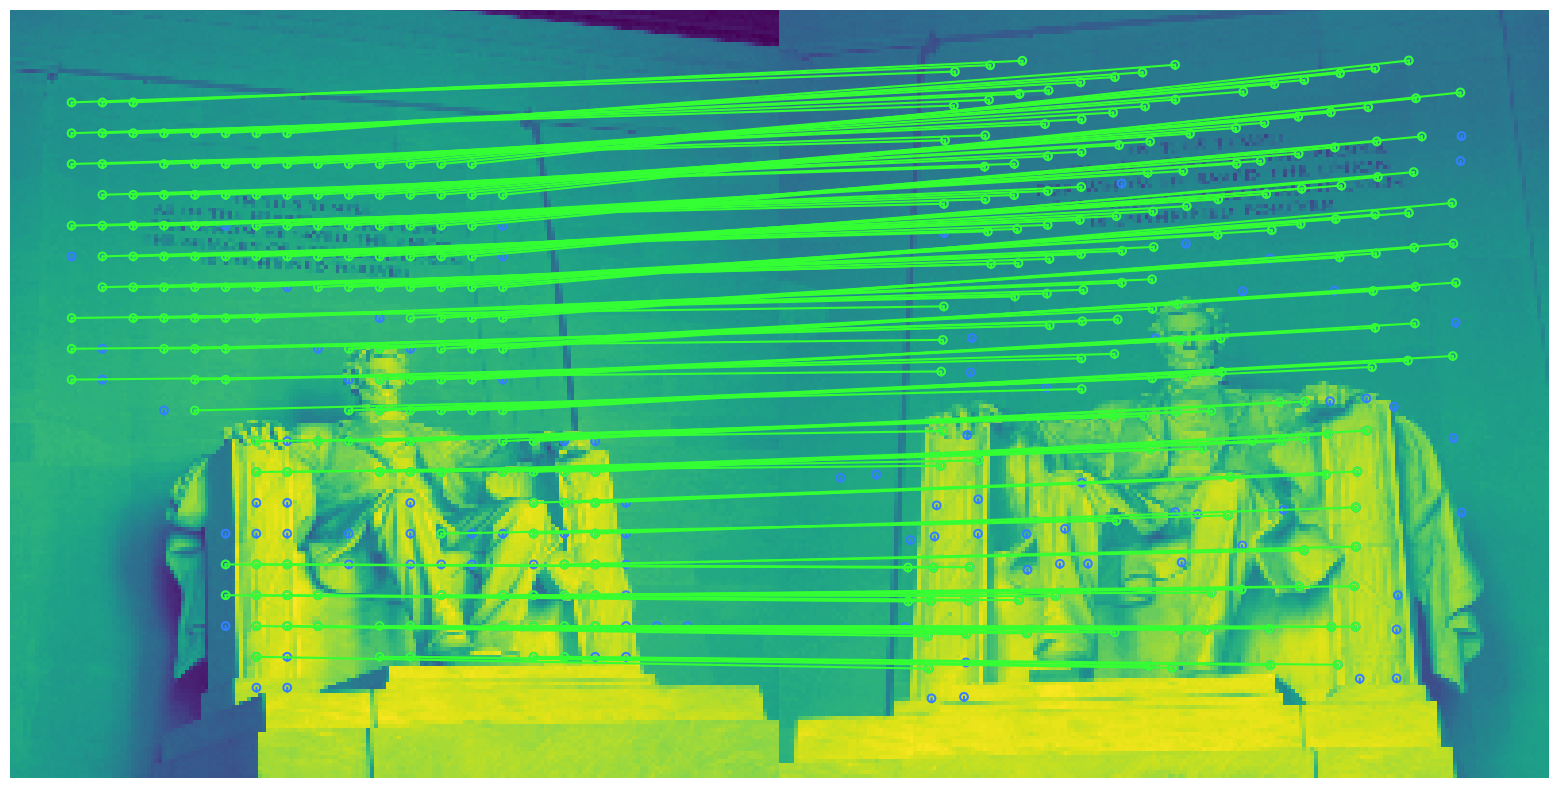

In [18]:
from kornia_moons.feature import *
import kornia.feature as KF
import kornia as K
Fm, inliers = cv.findFundamentalMat(mkpts0, mkpts1, cv.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

draw_LAF_matches(
    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts0).view(1,-1, 2),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts0.shape[0]).view(1,-1, 1)),

    KF.laf_from_center_scale_ori(torch.from_numpy(mkpts1).view(1,-1, 2),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1, 1),
                                torch.ones(mkpts1.shape[0]).view(1,-1, 1)),
    torch.arange(mkpts0.shape[0]).view(-1,1).repeat(1,2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={'inlier_color': (0.2, 1, 0.2),
               'tentative_color': None, 
               'feature_color': (0.2, 0.5, 1), 'vertical': False})
plt.axis("off")